Hierarchy:
    <Chart>
        <Series>
            <Value>
        <Graphs>
            <Graph>
                <Value>
        

#Libraries

In [379]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import cycler
import collections
import fnmatch, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import urllib.request as urllib2

from bs4 import BeautifulSoup
from pattern3 import web
from matplotlib import rcParams
from fnmatch import fnmatch
from datetime import datetime

#set some nicer defaults for matplotlib

In [ ]:
#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (20, 12)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler.cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [635]:
def get_poll_xml(can_id):
    """
    Given a poll_id, return the XML data as a text string
    >>> get_poll_xml(1044)
    u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
    """
    return requests.get("http://charts.realclearpolitics.com/charts/%d.xml"%(int(can_id))).text


def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)


def plot_colors(xml):
    """
    returns a python dictionary; that maps a graph title to a graph color.
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result


def rcp_poll_data(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = collections.defaultdict(list)
    for values in dom.by_tag('series'):
        for value in values:
            result['date'].append(value.content)
    for graph in dom.by_tag('graph'):
        for value in graph:
            try:
                result[graph.attributes['title']].append(float(value.content))
            except:
                result[graph.attributes['title']].append(value.content)
                
    result = pd.DataFrame(result)
    for col in result.columns[1:]:
        result = result[result[col].apply(lambda x: type(x) == float or type(x) == int)]
                
    
    return pd.DataFrame(result)


def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%  
    
    norm = data[colors.keys()].sum(axis=1)/ 100
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(np.arange(0, len(data), step=40), rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")
    
def find_governor_races(html):
    """ 
    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    """
    soup = BeautifulSoup(html)
            
    return list(set([link.get("href") for link in soup.find_all('a')
            if fnmatch(str(link.get("href")), "http://www.realclearpolitics.com/epolls/*/governor/*/*-*.html")]))

def race_result(url):
    """
    Return the actual voting results on a race page
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
    """
    soup = BeautifulSoup(requests.get(url).text) 
    soup = BeautifulSoup(str(soup.find("div", id = "polling-data-rcp"))) #revalue soup by new web.text
    names = []
    votes = []
    names_filled = False
    votes_filled = False
    for row in soup.find_all("tr"):
        if(row.get("class")==None and names_filled == False):
#             print([str(x.contents[0]) for x in row.find_all("th")  if re.search(r"^[A-Za-z]+ *\([A-Z]+\)", str(x.contents[0]))])
            names = [str(x.contents[0]) for x in row.find_all("th") if re.search(r"^[A-Za-z]+ +\([A-Z]+\)", str(x.contents[0]))]
            if (names!=[]): names_filled = True
        if(row.get("class")==['final'] and votes_filled == False):
            votes = [float(x.contents[0]) for x in row.find_all("td") if re.search("^[0-9]+\.[0-9]+", str(x.contents[0]))]
            if (votes!=[]): votes_filled = True
                
        if (names_filled and votes_filled): break
    votes_normalized = [100*vote/np.sum(votes) for vote in votes]
    return dict(zip(names, votes_normalized))


def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)[:-1]], alpha=0.6, ls='--')
        
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'

def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race reulst
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    
    id = id_from_url(url)
    xml = get_poll_xml(id)
    
    colors = plot_colors(xml)
    if len(colors) == 0:
        return pd.DataFrame()
    
    df = rcp_poll_data(xml)
    result = race_result(url)
    
    #remove non-letter characters from columns
    df = df.rename(columns={c: _strip(c) for c in df.columns})
    result_tmp = {}
    for k, v in result.items():
        result_tmp[_strip(k)[:-1]] = v 
    result = result_tmp
    
    candidates = [c for c in df.columns if c is not 'date']
        
    #turn into a timeseries...
    df.index = [datetime.strptime(str(x), "%m/%d/%Y")  for x in list(df.date)]
    df.date = df.index.copy()
    
    #...so that we can resample at regular, daily intervals
    old_df = df.copy()
    df = df.resample('D')
#     df = df.dropna()
    
    #compute forecast length in days
    #(assuming that last forecast happens on the day of the election, for simplicity)
    
    forecast_length = pd.Series([old_df.date.max()- x for x in old_df.date.values])
    forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    
    #compute forecast error
    errors = {}
    normalized = {}
    poll_lead = {}
    
    df = old_df.resample('D').sum()
    
    for c in candidates:
        #turn raw percentage into percentage of poll votes
        corr = df[c].values / df[candidates].sum(axis=1).values * 100
        err = corr - result[_strip(c)]
        
        normalized[c] = corr
        errors[c] = err
        
        
    n = forecast_length.size
    
    result = {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[_strip(c)]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    
    result = pd.DataFrame(result)
    return result



#Single Function Test code

In [636]:
rcp_poll_data(get_poll_xml(1171)).head()

,date,Obama,Romney
0,2/01/2011,47.5,41.5
1,2/02/2011,47.5,41.5
2,2/03/2011,47.5,41.5
3,2/04/2011,47.5,41.5
4,2/05/2011,47.5,41.5


Text(0.5, 1.0, 'Obama Job Approval')

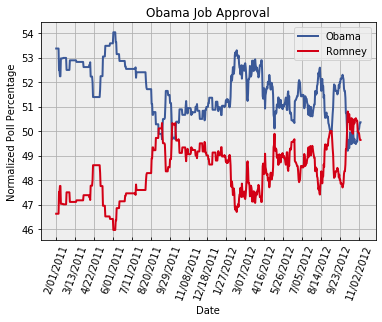

In [637]:
poll_plot(1171)
plt.title("Obama Job Approval")

In [638]:
html = requests.get("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html")
find_governor_races(html.text)

['http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html',
 'http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html']

In [641]:

url = "http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html"
race_result(url)

{'McDonnell (R)': 58.75875875875875, 'Deeds (D)': 41.24124124124124}

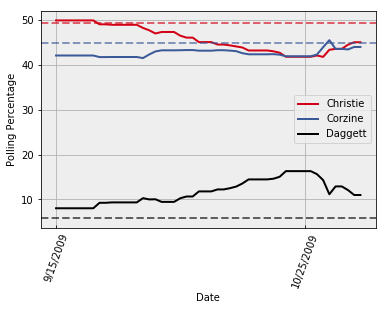

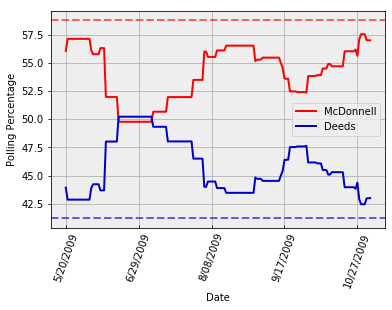

In [646]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')


for race in find_governor_races(page):
    plot_race(race)
    plt.xticks(rotation=70)
    plt.show()

In [505]:
error_data(url).head()

168


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support 

,percentage,error,candidate,party,forecast_length
0,56.062581,-2.696177,McDonnell,republican,167.0
1,57.124842,-1.633916,McDonnell,republican,166.0
2,57.124842,-1.633916,McDonnell,republican,165.0
3,57.124842,-1.633916,McDonnell,republican,164.0
4,57.124842,-1.633916,McDonnell,republican,163.0


In [593]:
def all_error_data():
    """
    Calls error_data on all races from find_governer_races(page)
    and concatenates into a single DataFrame
    """
    re_df = pd.DataFrame()
    re_df = pd.concat([error_data(race) for race in find_governor_races(page)], ignore_index=True)
    return re_df
errors = all_error_data()
errors

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:244: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:245: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:246: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Supp

,percentage,error,candidate,party,forecast_length
0,56.062581,-2.696177,McDonnell,republican,167.0
1,57.124842,-1.633916,McDonnell,republican,166.0
2,57.124842,-1.633916,McDonnell,republican,165.0
3,57.124842,-1.633916,McDonnell,republican,164.0
4,57.124842,-1.633916,McDonnell,republican,163.0
5,57.124842,-1.633916,McDonnell,republican,162.0
6,57.124842,-1.633916,McDonnell,republican,161.0
7,57.124842,-1.633916,McDonnell,republican,160.0
8,57.124842,-1.633916,McDonnell,republican,159.0
9,57.124842,-1.633916,McDonnell,republican,158.0


Text(0, 0.5, 'N')

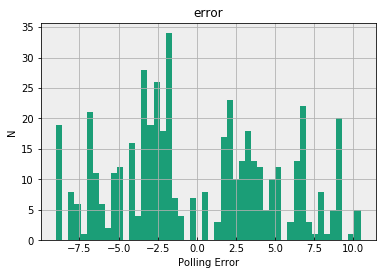

In [594]:
errors.filter(regex = ("error*")).hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

Text(0, 0.5, 'Error Standard Deviation')

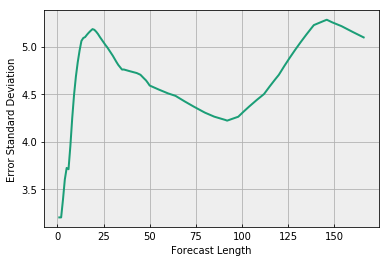

In [553]:
std_list = []
std_list = [np.std(errors[errors.forecast_length <i].error) for i in range(int(errors.forecast_length.max()))]
    
plt.plot(range(int(errors.forecast_length.max())), std_list)
plt.xlabel("Forecast Length")
plt.ylabel("Error Standard Deviation")

In [623]:
import random
import itertools
import time

def PredictResultByBoostrap(hitorical_error, c1, c2, B = 10000):

    N = errors.shape[0]
    B = B
    resam_error_list = []

    np.random.seed(int(time.time()))
    resam_error_list = [errors.error.values[j] for j in np.random.randint(N, size = B)]

    c1_actual = pd.Series([c1-x for x in resam_error_list])
    c2_actual = pd.Series([c2+x for x in resam_error_list])
    
    p1 = (c1_actual > c2_actual).mean()
    p2 = 1-p1
    return p1, p2

c1, c2 = 43.0, 39.0

p1, p2 = PredictResultByBoostrap(errors, c1, c2)


# plt.hist(resam_error_list, bins=int(B/10))
# plt.xlabel("Polling Error")
# plt.ylabel('Resample Standard Deviation of Errors')

#Main Function

/anaconda3/lib/python3.7/site-packages/pattern3/web/__init__.py:3375: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 3375 of the file /anaconda3/lib/python3.7/site-packages/pattern3/web/__init__.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  self._p = bs4.BeautifulSoup(decode_string(html), **kwargs) if not isinstance(html, SOUP) else html


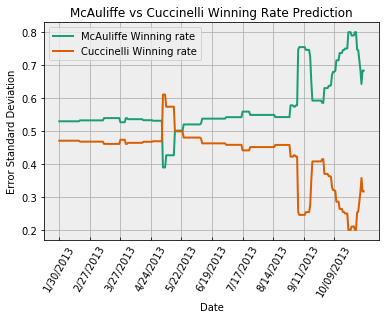

In [684]:
polling_id = 3033
main_df = rcp_poll_data(get_poll_xml(polling_id))
errors = all_error_data()
pre_l = [PredictResultByBoostrap(errors, c[0], c[1]) 
         for c in zip(main_df[main_df.columns[1]],main_df[main_df.columns[2]])]
names_winning_rate = [str(x) + " Winning rate" for x in main_df.columns[1:3]]

win_dict = dict(zip(names_winning_rate, list(zip(*pre_l))))

main_df_rate = pd.concat([main_df, pd.DataFrame(win_dict)], axis = 1)
for col in main_df_rate.filter(like = ("Winning rate")):
    plt.plot(main_df_rate.date, main_df_rate[col])
    
plt.xticks(np.arange(0, main_df_rate.date.size, step = int(main_df_rate.date.size/10)), rotation = 60)
plt.title("%s vs %s Winning Rate Prediction"%(main_df_rate.columns[1], main_df_rate.columns[2]))
plt.xlabel("Date")
plt.ylabel("Error Standard Deviation")
plt.legend(loc='best')
plt.show()